<a href="https://colab.research.google.com/github/jfthuong/PySvn/blob/master/Recognize_Actors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
from pathlib import Path
from pprint import pprint
from typing import Dict, List

In [2]:
!pip install -Uqq fastbook fastai
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 188 kB 10.9 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 1.2 MB 17.2 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 
     |████████████████████████████████| 51 kB 245 kB/s 
Mounted at /content/gdrive


In [3]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  ACTORS_DIR = Path("/content/drive/MyDrive/actors")

except ImportError:
  print("WARNING: Google Drive not detected: using local directory instead")
  ACTORS_DIR = Path("actors")

thumb_dir = ACTORS_DIR / "thumbnails"
download_dir = ACTORS_DIR / "download"

Mounted at /content/drive


In [4]:
START_CLEAN = False
# Set to TRUE to clean-up folder when starting

EXPORT_PATH = ACTORS_DIR / "actor_model_v2.pkl"

# Listing top 100 Actors

We will extract a list of actors from IMDB, by using BeautifulSoup.
We will keep a picture of each actor to serve as a test set.

We will also do some sanity checks to verify that we have 100 correct thumbnails.


In [ ]:
import requests

from bs4 import BeautifulSoup

URL = "https://www.imdb.com/list/ls050274118/"


In [ ]:
# Instead of doing star import :)
from fastai.data.transforms import get_image_files
from fastai.vision.utils import verify_images
from fastdownload.core import download_url

In [ ]:
resp = requests.get(URL)
soup = BeautifulSoup(resp.content, 'html.parser')

In [ ]:

thumb_dir.mkdir(exist_ok=True, parents=True)

actors_100: List[str] = list()
for img in soup.find_all("img"):
    name = img.get("alt")
    # Name of actors start with an upper case.
    # Otherwise, there is another item: "list image"
    if not name[0].isupper():
        continue
    actors_100.append(name)
    dest = thumb_dir / f"{name}.jpg"
    if not dest.is_file():
      download_url(img.get("src"), dest, show_progress=False)

In [ ]:
nb_thumbnails_downloaded = len(list(thumb_dir.glob("*.jpg")))
assert nb_thumbnails_downloaded == 100, f"{nb_thumbnails_downloaded} thumbnails found, 100 expected"
  

In [ ]:
actors_thumbs = get_image_files(thumb_dir)
failed_thumbs = verify_images(actors_thumbs)
try:
  assert not failed_thumbs, f"Images corrupted: {failed_thumbs}: please download again"
except AssertionError:
  failed_thumbs.map(Path.unlink)
  raise

# Downloading images for actors

In [ ]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    AZURE_SEARCH_KEY = user_secrets.get_secret("AZURE_SEARCH_KEY")

except ImportError:
    AZURE_SEARCH_KEY = os.environ.get(
        "AZURE_SEARCH_KEY",
        (ACTORS_DIR.parent / "AZURE_SEARCH_KEY").read_text()
    )

assert AZURE_SEARCH_KEY, "Empty key for search with Bing"

In [ ]:
for i, actor in enumerate(actors_100, start=1):
  print(f"#{i:03d}: {actor}")

#001: Jack Nicholson
#002: Marlon Brando
#003: Robert De Niro
#004: Al Pacino
#005: Daniel Day-Lewis
#006: Dustin Hoffman
#007: Tom Hanks
#008: Anthony Hopkins
#009: Paul Newman
#010: Denzel Washington
#011: Spencer Tracy
#012: Laurence Olivier
#013: Jack Lemmon
#014: Michael Caine
#015: James Stewart
#016: Robin Williams
#017: Robert Duvall
#018: Sean Penn
#019: Morgan Freeman
#020: Jeff Bridges
#021: Sidney Poitier
#022: Peter O'Toole
#023: Clint Eastwood
#024: Gene Hackman
#025: Charles Chaplin
#026: Ben Kingsley
#027: Philip Seymour Hoffman
#028: Leonardo DiCaprio
#029: Russell Crowe
#030: Kevin Spacey
#031: Humphrey Bogart
#032: Gregory Peck
#033: Clark Gable
#034: Gary Cooper
#035: George C. Scott
#036: Jason Robards
#037: Charles Laughton
#038: Anthony Quinn
#039: Peter Sellers
#040: James Cagney
#041: Peter Finch
#042: Henry Fonda
#043: Cary Grant
#044: Richard Burton
#045: Burt Lancaster
#046: William Holden
#047: John Wayne
#048: Kirk Douglas
#049: Alec Guinness
#050: Christo

In [ ]:
if START_CLEAN:
  shutil.rmtree(download_dir, ignore_errors=True)


for actor in actors_100[:50]:
  dest = download_dir / actor
  # We will only download if we don't have the folder or we have less than 250 pictures in it
  if not dest.is_dir() or len(list(dest.iterdir())) < 225:
    print(f"Downloading images for {actor} in {dest}")
    dest.mkdir(exist_ok=True, parents=True)
    for age in ["young", "old"]:
      results = search_images_bing(AZURE_SEARCH_KEY, f'"{actor}" {age}')
      download_images(dest / f"{actor}_{age}", urls=results.attrgot('contentUrl'))


In [ ]:
# As we can have jpg, JPEG, gif, png, ..., we will do a glob based on hierarchy
for img in download_dir.glob("*/*/*.*"):
    actor, age = img.parent.name.split("_")
    actor_dir = img.parent.parent
    assert actor_dir.name == actor, f"{actor_dir} not matching name of actor {actor}"
    img.rename(actor_dir / f"{actor}-{age}-{img.name}")

# We will then check that all files have been copied and clean up directories


In [ ]:
for path in download_dir.glob("*/*"):
  if path.is_dir() and path.name.endswith(("_young", "_old")):
    nb_files = len(list(path.glob("*.*")))
    if nb_files:
      print(f"Directory {path} not empty ({nb_files} children)")
    else:
      path.rmdir()
      print(f"Deleted empty directory {path}")

Deleted empty directory /content/drive/MyDrive/actors/download/Jack Lemmon/Jack Lemmon_young
Deleted empty directory /content/drive/MyDrive/actors/download/Jack Lemmon/Jack Lemmon_old
Deleted empty directory /content/drive/MyDrive/actors/download/Michael Caine/Michael Caine_young
Deleted empty directory /content/drive/MyDrive/actors/download/Michael Caine/Michael Caine_old
Deleted empty directory /content/drive/MyDrive/actors/download/James Stewart/James Stewart_young
Deleted empty directory /content/drive/MyDrive/actors/download/James Stewart/James Stewart_old
Deleted empty directory /content/drive/MyDrive/actors/download/Robin Williams/Robin Williams_young
Deleted empty directory /content/drive/MyDrive/actors/download/Morgan Freeman/Morgan Freeman_old
Deleted empty directory /content/drive/MyDrive/actors/download/Jeff Bridges/Jeff Bridges_young
Deleted empty directory /content/drive/MyDrive/actors/download/Jeff Bridges/Jeff Bridges_old
Deleted empty directory /content/drive/MyDrive/a

In [17]:
actors_fns = get_image_files(download_dir)
failed = verify_images(actors_fns)


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [18]:
from collections import defaultdict
corrupted_images_dir = defaultdict(int)
for p in failed:
  corrupted_images_dir[p.parent] += 1

print(f"Cleaning up {len(failed)} corrupted images in {download_dir}:")
for dir_, nb in corrupted_images_dir.items():
  print(f" * {dir_}: {nb:02d} images corrupted")

failed.map(Path.unlink)
print("=> done")

Cleaning up 0 corrupted images in /content/drive/MyDrive/actors/download:
=> done


# Learning (CV)

In [5]:
# We gist list of actors in order
actors_ordered = list(pd.read_csv(ACTORS_DIR / "top_100_actors.csv")["Name"])
actors_ordered[:10]

['Jack Nicholson',
 'Marlon Brando',
 'Robert De Niro',
 'Al Pacino',
 'Daniel Day-Lewis',
 'Dustin Hoffman',
 'Tom Hanks',
 'Anthony Hopkins',
 'Paul Newman',
 'Denzel Washington']

In [6]:
# We reload the name of actors for which we have downloaded pictures
actors = [d.name for d in download_dir.glob("*") if d.is_dir()]
len(actors)

56

In [7]:
from fastai.data.block import DataBlock

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```
These lines implement a fastai data augmentation strategy which we call presizing. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

In [8]:
actors_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    # item_tfms=RandomResizedCrop(224, min_scale=0.5),
    # batch_tfms=aug_transforms(mult=1.1, max_warp=0.1, max_lighting=0.3)
)


In [9]:
actors_block.summary(download_dir)

Setting-up type transforms pipelines
Found 15733 items
2 datasets of sizes 12587,3146
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/actors/download/James Cagney/James Cagney-young-00000039.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1401x788
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/actors/download/James Cagney/James Cagney-young-00000039.jpg
    applying parent_label gives
      James Cagney
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(25)

Final sample: (PILImage mode=RGB size=1401x788, TensorCategory(25))


Found 15733 items
2 datasets of sizes 12587,3146
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Catego

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)



Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
    starting from
      (PILImage mode=RGB size=1401x788, TensorCategory(25))
    applying Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} gives
      (PILImage mode=RGB size=460x460, TensorCategory(25))
    applying ToTensor gives
      (TensorImage of size 3x460x460, TensorCategory(25))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0

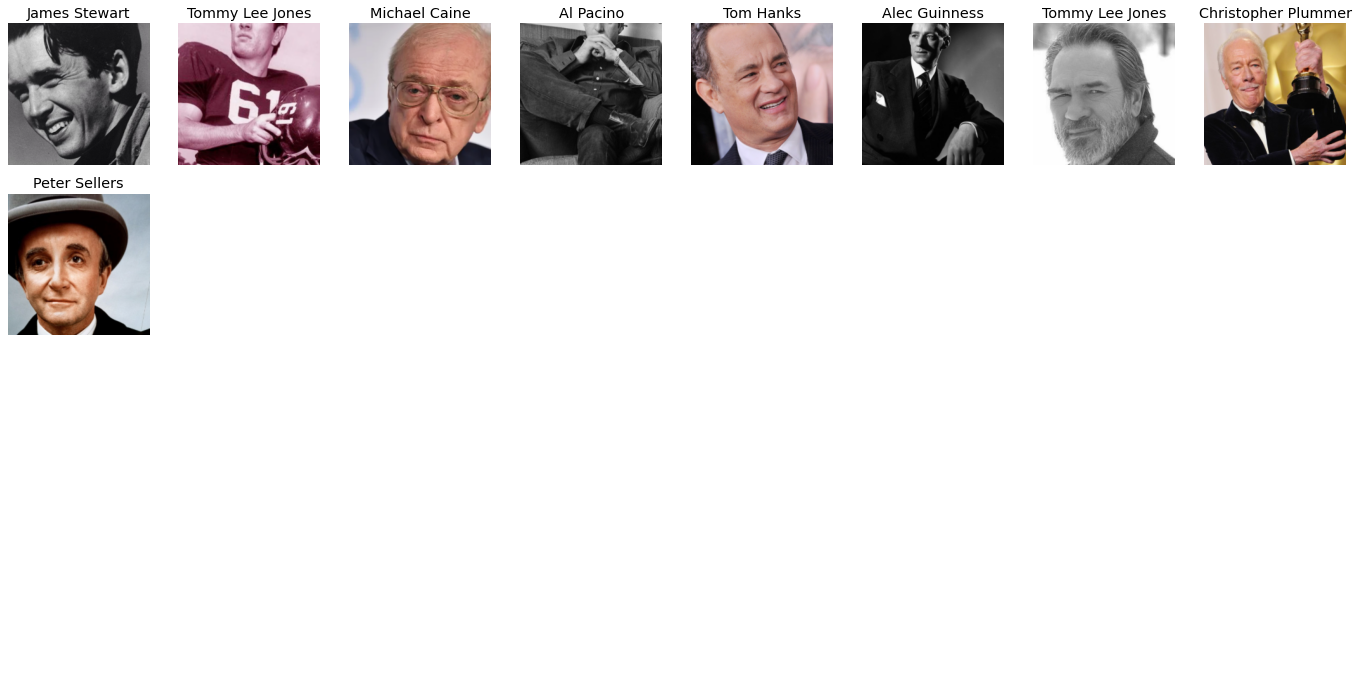

In [10]:
dls = actors_block.dataloaders(download_dir)
dls.train.show_batch(ncols=8, nrows=4)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


ValueError: ignored

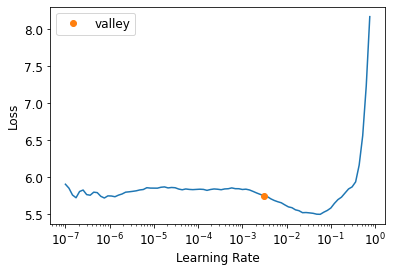

In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()
f"MIN={lr_min:.2e}  --   STEEP:{lr_steep:.2e}"

In [ ]:
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,4.149325,2.970136,0.736491,06:07


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,3.000365,2.329263,0.587095,06:12
1,2.479738,1.920789,0.487285,06:12
2,2.086792,1.660484,0.412905,06:14
3,1.773249,1.447998,0.367769,06:12
4,1.459060,1.336664,0.327082,06:15
5,1.273470,1.225276,0.303242,06:10
6,1.114525,1.154660,0.285760,06:12
7,1.015438,1.167834,0.278767,06:13
8,0.830896,1.062153,0.259695,06:15
9,0.719851,1.090276,0.258423,06:15


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.w

epoch,train_loss,valid_loss,error_rate,time
0,3.000365,2.329263,0.587095,06:12
1,2.479738,1.920789,0.487285,06:12
2,2.086792,1.660484,0.412905,06:14
3,1.773249,1.447998,0.367769,06:12
4,1.459060,1.336664,0.327082,06:15
5,1.273470,1.225276,0.303242,06:10
6,1.114525,1.154660,0.285760,06:12
7,1.015438,1.167834,0.278767,06:13
8,0.830896,1.062153,0.259695,06:15
9,0.719851,1.090276,0.258423,06:15


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(12, 12))

## Cleaning

In [ ]:
interp.plot_top_losses(20, nrows=5, figsize=(25, 25))

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]), path/cat)

## Improving Model

## Checking thumbnails

In [ ]:
for thumb in thumb_dir.glob("*.jpg"):
  actor = thumb.stem
  if not (download_dir / actor).is_dir():
    continue
  actor_pred, pred_idx, probs = learn.predict(thumb)
  prob_pct = f"{probs[pred_idx] * 100:.2f}%"
  if actor == actor_pred:
    print(f"OK: Correct prediction of '{actor}' (prob: {prob_pct})")
  else:
    print(f"KO: Predicted '{actor}' was '{actor_pred}' with confidence of {prob_pct}")

## Export Model

In [ ]:
learn.export(EXPORT_PATH)

# Who are you?

We will re-import the exported model
We will tell you which actor you are closer to (physically) ...

In [ ]:
# Because there are some issues in Windows
from contextlib import contextmanager

@contextmanager
def set_posix_windows():
    posix_backup = pathlib.PosixPath
    try:
        pathlib.PosixPath = pathlib.WindowsPath
        yield
    finally:
        pathlib.PosixPath = posix_backup


In [ ]:
with set_posix_windows():
  learn_inf = load_learner(EXPORT_PATH)

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


You physically look like Daniel Day-Lewis, with a similarity of 98.7%


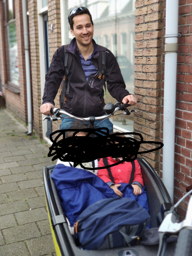

In [ ]:
img = PILImage.create(uploader.data[0])
pred, pred_idx, probs = learn_inf.predict(img)
print(f'You physically look like {pred}, with a similarity of {probs[pred_idx] * 100:.1f}%')
display(img.to_thumb(256, 256))